In [1]:
# coding: utf-8

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import time

def log(text, t_start=None):
    if t_start is None:
        print(text)
    else:
        elapsed_time = round(time.time() - t_start, 2)
        print(text + "\t(" + str(elapsed_time) + "s)")

### Loading files

In [2]:
t = time.time()
customers = pd.read_csv("data/customers.csv")
products = pd.read_csv("data/products.csv")
x_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv")
x_test = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/y_test.csv")
log("files loaded", t)

files loaded	(7.83s)


In [3]:
SizeAdviceDescriptionCleaner = {}
SizeAdviceDescriptionCleaner['nan'] = 0
SizeAdviceDescriptionCleaner['Ce mod\xc3\x83\xc2\xa8le chausse normalement'] = 0
SizeAdviceDescriptionCleaner['Mod\xc3\x83\xc2\xa8le confortable, convient aux pieds larges'] = -.5
SizeAdviceDescriptionCleaner['Mod\xc3\x83\xc2\xa8le \xc3\x83\xc2\xa9troit, convient aux pieds fins'] = .5
SizeAdviceDescriptionCleaner['Prenez votre pointure habituelle'] = 0
SizeAdviceDescriptionCleaner['Chaussant particuli\xc3\x83\xc2\xa8rement g\xc3\x83\xc2\xa9n\xc3\x83\xc2\xa9reux. Nous vous conseillons de choisir deux tailles en dessous de votre pointure habituelle.'] = -2
SizeAdviceDescriptionCleaner['Chaussant petit. Si vous \xc3\x83\xc2\xaates habituellement entre deux pointures, nous vous conseillons de choisir une demi taille au-dessus de votre pointure habituelle.'] = .5
SizeAdviceDescriptionCleaner['Prenez une taille au-dessus de sa pointure !'] = 1
SizeAdviceDescriptionCleaner['Prenez une taille au-dessus de votre pointure habituelle'] = 1
SizeAdviceDescriptionCleaner['Prenez une taille en dessous de sa pointure !'] = -1
SizeAdviceDescriptionCleaner['Prenez une taille en dessous de votre pointure habituelle'] = -1

In [27]:
def age(birthdate):
    if type(birthdate) == type(" "):
        return 2016 - int(birthdate[:4])
    return None

def order_season(orderdate):
    month = int(orderdate[5:7])
    if month >= 4 and month <= 9:
        return "Printemps/Et\xc3\x83\xc2\xa9"
    return "Automne/Hiver"

In [ ]:
def build_df(x):
    t = time.time()
    
    m = None
    
    # join
    m = pd.merge(x, products, how='left', on='VariantId', suffixes=('_pr', ''))
    m = pd.merge(m, customers, how='left', on='CustomerId', suffixes=('_cs', ''))
    
    # converting UnitPMPEUR
    m.UnitPMPEUR = [float(row.replace(',', '.')) for row in m.UnitPMPEUR]
    
    # building news columns
    m["MatchGender"] = m["Gender"] == m["GenderLabel"]
    m["MatchSeason"] = m["SeasonLabel_pr"] == m["SeasonLabel"]
    m["OrderSeason"] = m["OrderCreationDate"].map(order_season)
    m["MatchOrderSeason"] = m["OrderSeason"] == m["SeasonLabel"]
    
    # cleaning
    m["SizeAdviceDescription"] = m["SizeAdviceDescription"].map(SizeAdviceDescriptionCleaner)
    m["BirthDate"] = m["BirthDate"].map(age)
        
    # removing useless columns
    blacklist = ['VariantId', 'CustomerId', 'OrderNumber', 'LineItem',
                 'ProductColorId', 'BrandId', 'SupplierColor', 'OrderShipDate',
                 'ProductId', 'BillingPostalCode', 'FirstOrderDate',
                 'OrderStatusLabel', 'MinSize', 'MaxSize', 'OrderSeason',
                 'OrderCreationDate', 'SubtypeLabel', 'CountryISOCode',
                 'ProductType', 'IsoCode'
                ]
    whitelist = None
    if blacklist is not None:
        m = m.drop(blacklist, axis=1)
    if whitelist is not None:
        for col in m.columns:
            if col not in whitelist:
                m = m.drop([col], axis=1)

    print "dataframe shape:", m.shape
    log("dataframe built", t)
    return m

df_train = build_df(x_train)
df_test = build_df(x_test)

dataframe shape: (1067290, 32)
dataframe built	(12.32s)
dataframe shape: (800468, 32)
dataframe built	(6.36s)


### Statistics

In [6]:
def column_stat(x, y, col, step=100, verbose=True):
    print "\n----- " + col + " -----"
    dictionnary = {}
    for i, o in x.loc[::step].iterrows():
        if str(o[col]) not in dictionnary.keys():
            dictionnary[str(o[col])] = [0., 0.]
        if y.loc[i, ["ReturnQuantityBin"]][0] == 0.0:
            dictionnary[str(o[col])][0] += 1.
        else:
            dictionnary[str(o[col])][1] += 1.
    values = []
    for val, (zeros, ones) in dictionnary.items():
        values.append((ones / (zeros + ones)))
        if verbose:
            print val, "\t", values[-1], "returns"
    variance = np.var(values)
    print "variance:", round(variance, 5), "\tvalue count:", len(values)
    return variance, variance / len(values)

def string_stats(x, y, verbose=False):
    ignored = []
    labels = []
    variability = []
    relative_variability = []
    for col in x.columns:
        if x[col].dtype in ["object", "bool"]:
            labels.append(col)
            var, rel = column_stat(x, y, col, verbose=verbose)
            variability.append(var)
            relative_variability.append(rel)
        else:
            ignored.append(col)
    print "\nignored columns:", ignored
    return labels, variability, relative_variability

labels, variability, relative_variability = string_stats(df_train, y_train)


----- OrderTypelabel -----
variance: 0.00017 	value count: 2

----- SeasonLabel_pr -----
variance: 7e-05 	value count: 2

----- PayementModeLabel -----
variance: 0.00472 	value count: 10

----- CustomerTypeLabel -----
variance: 0.00022 	value count: 2

----- IsoCode -----
variance: 0.04536 	value count: 20

----- DeviceTypeLabel -----
variance: 0.00124 	value count: 4

----- PricingTypeLabel -----
variance: 0.00072 	value count: 5

----- GenderLabel -----
variance: 0.00338 	value count: 6

----- MarketTargetLabel -----
variance: 0.00735 	value count: 14

----- SeasonLabel -----
variance: 0.00025 	value count: 3

----- SeasonalityLabel -----
variance: 0.00057 	value count: 4

----- UniverseLabel -----
variance: 0.00268 	value count: 9

----- TypeBrand -----
variance: 0.00581 	value count: 4

----- ProductType -----
variance: 0.00893 	value count: 30

----- SubtypeLabel -----
variance: 0.03809 	value count: 44

----- UpperMaterialLabel -----
variance: 0.00883 	value count: 9

----- Lini

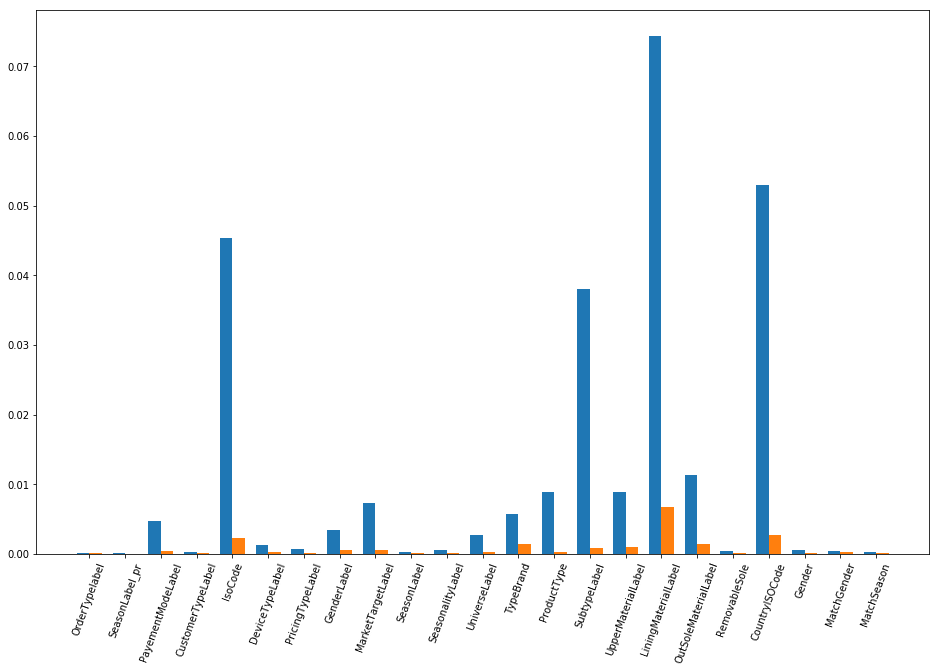

In [7]:
def plot_variances(labels, values_l, values_r):
    fig, ax = plt.subplots(figsize=(16,10))
    ind = np.arange(len(values_l))
    width = .35
    ax.bar(ind - width/2, values_l, width)
    ax.bar(ind + width/2, values_r, width)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    plt.xticks(rotation=70)

plot_variances(labels, variability, relative_variability)


----- TotalLineItems -----


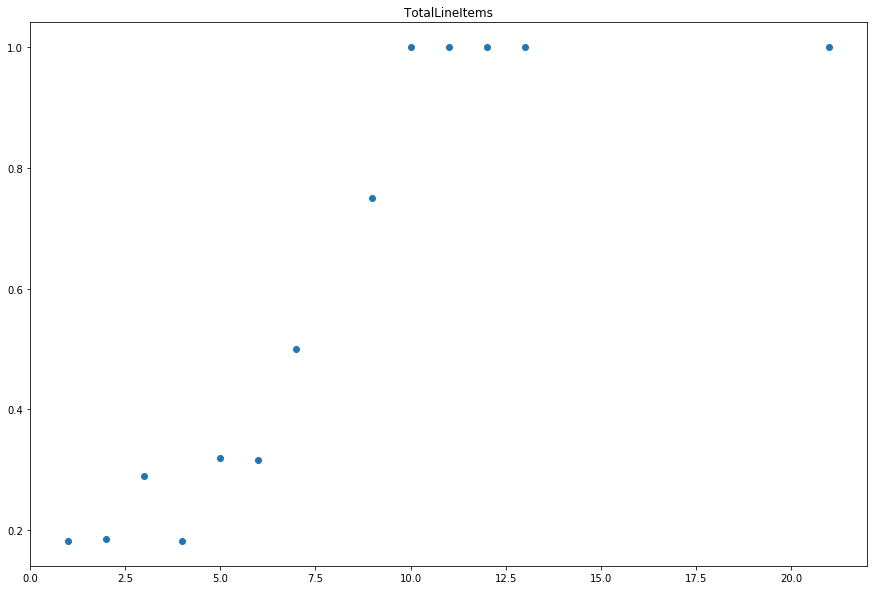


----- Quantity -----


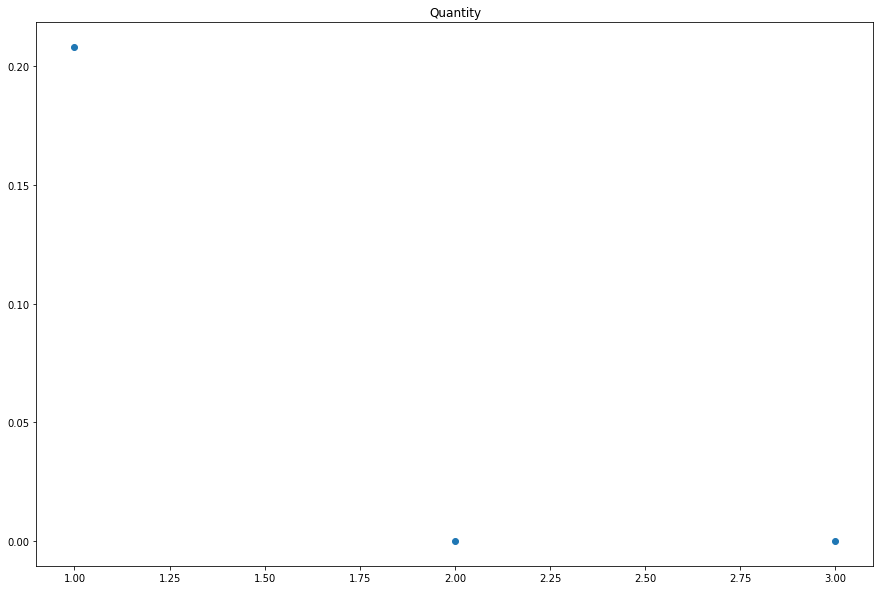


----- UnitPMPEUR -----


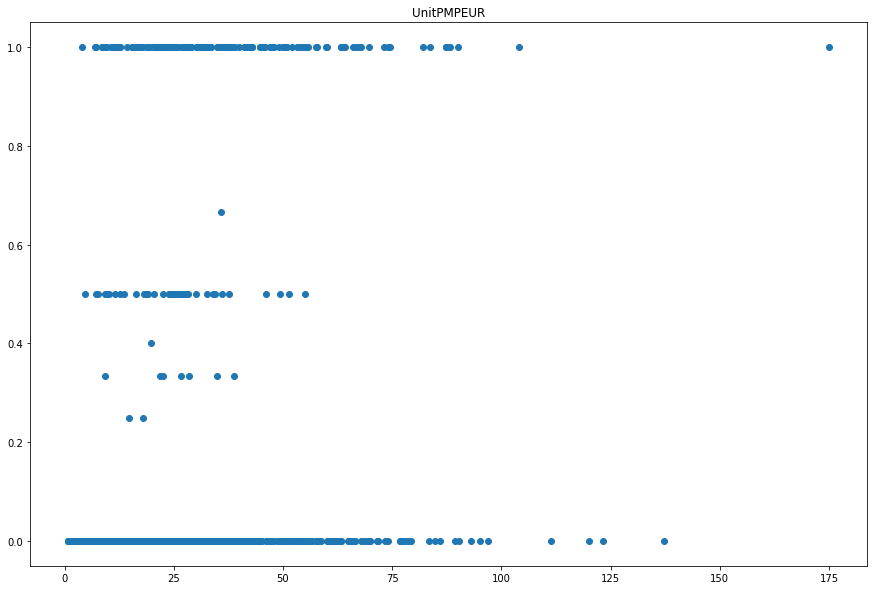


----- OrderNumCustomer -----


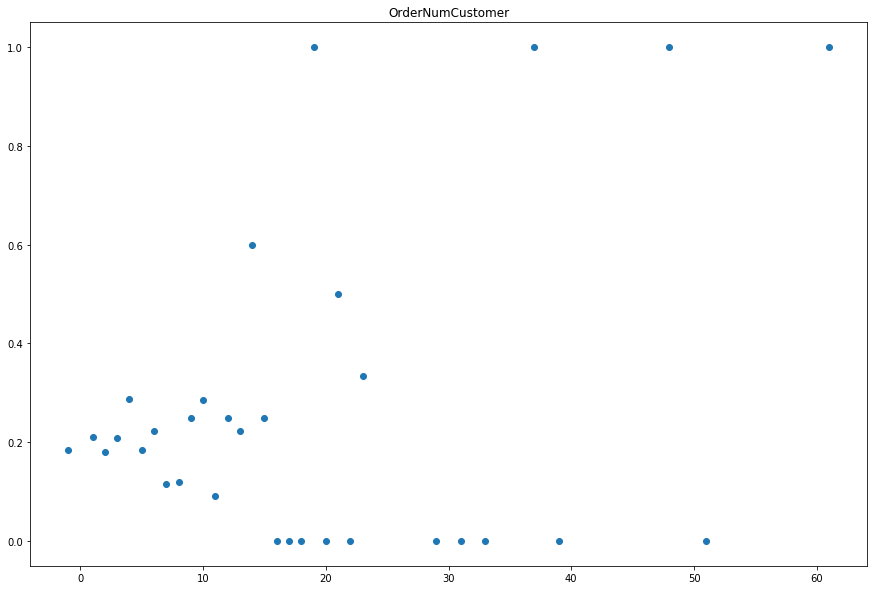


----- IsOnSale -----


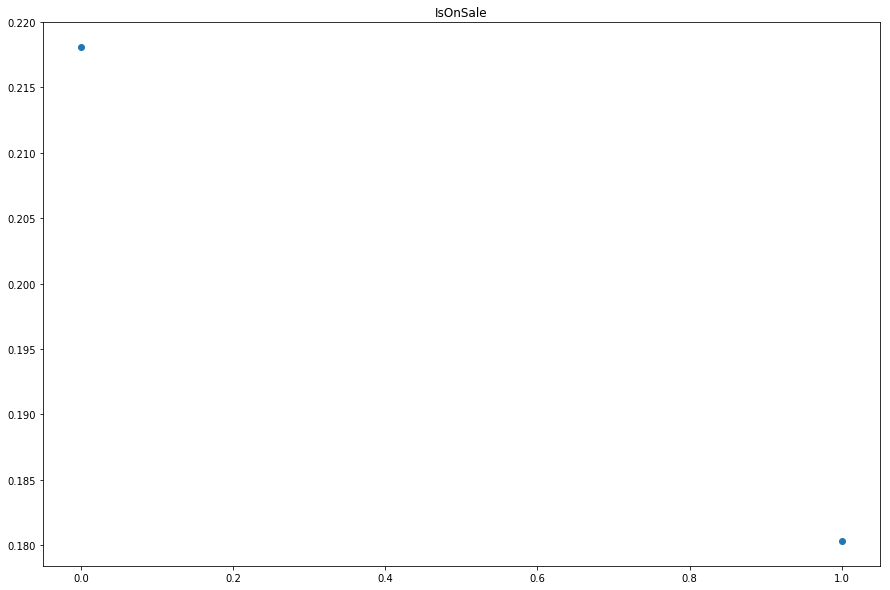


----- CalfTurn -----


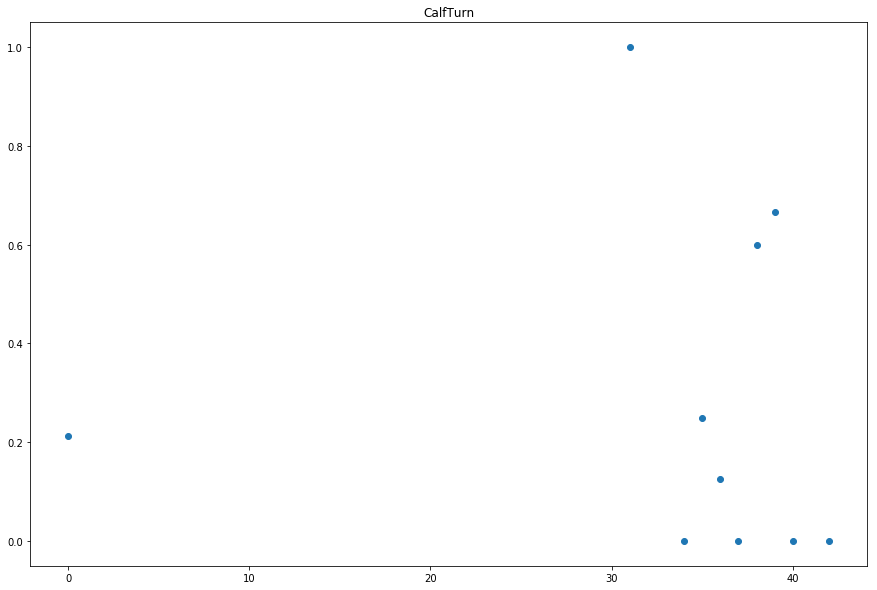


----- UpperHeight -----


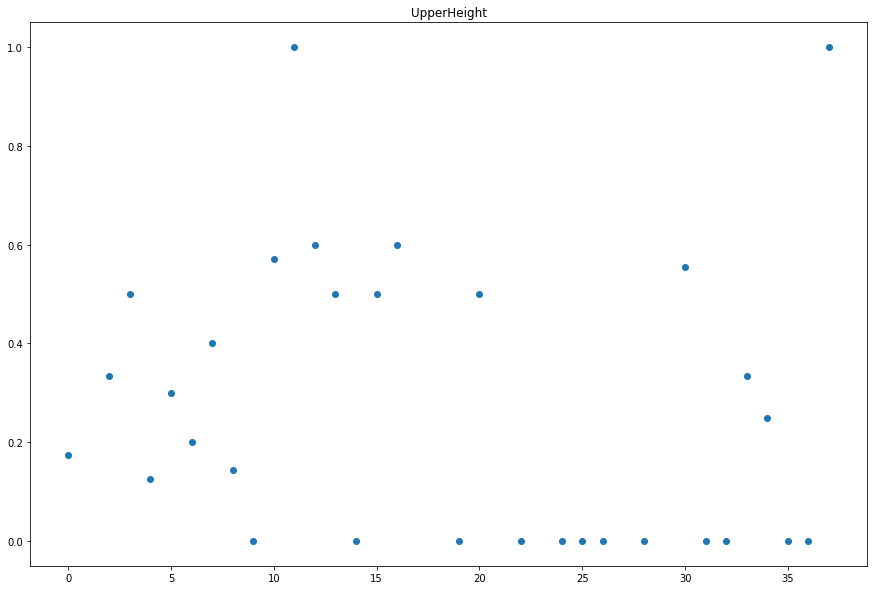


----- HeelHeight -----


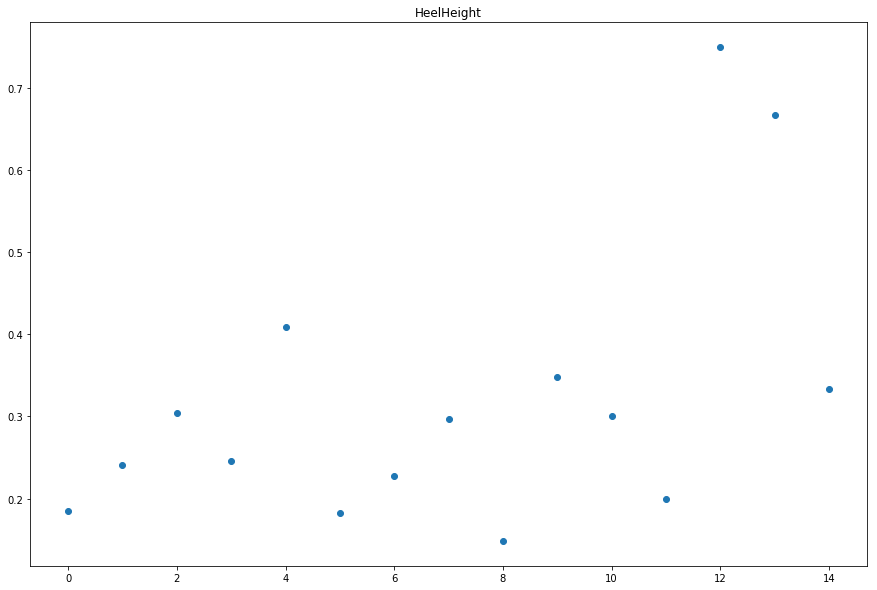


----- PurchasePriceHT -----


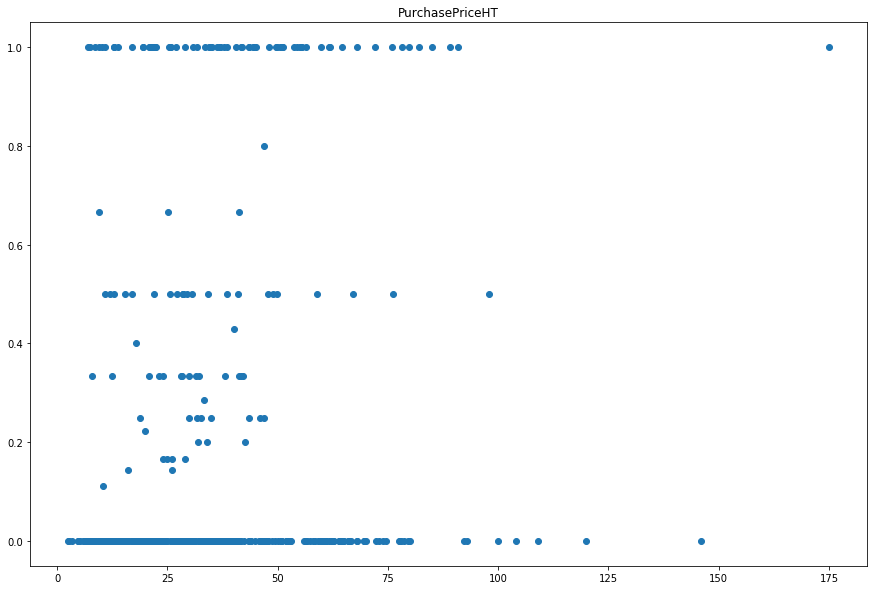


----- IsNewCollection -----


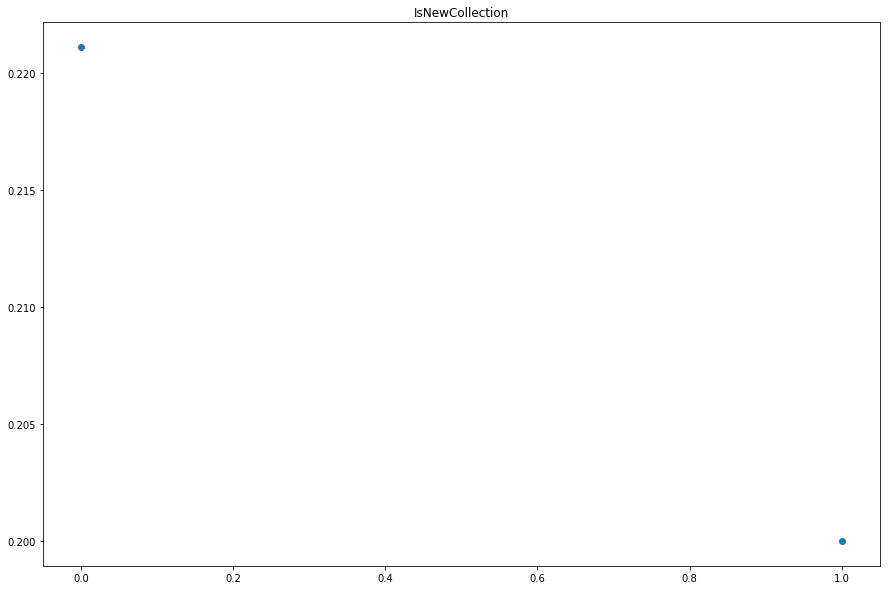


----- SizeAdviceDescription -----


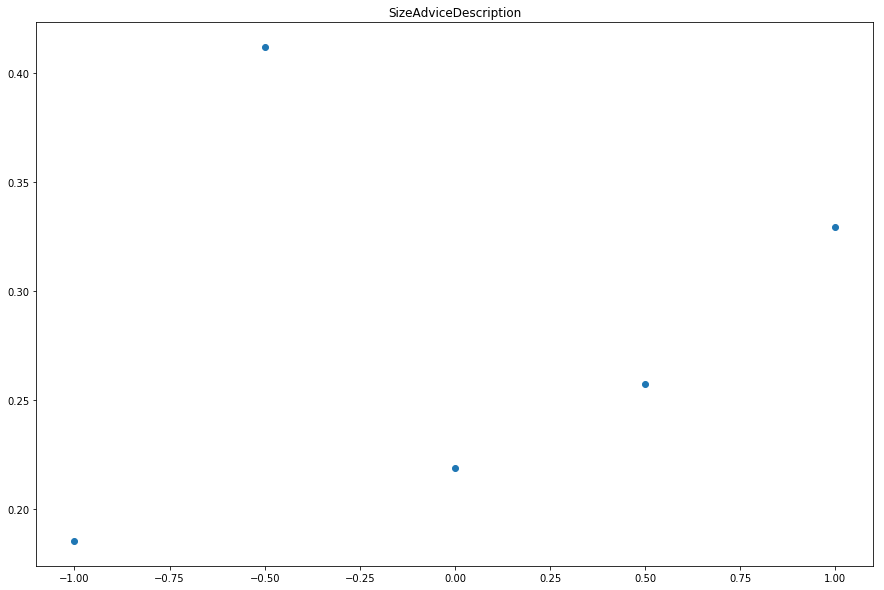

In [8]:
def column_stat_cont(x, y, col, step=100):
    print "\n----- " + col + " -----"
    dictionnary = {}
    for i, o in x.loc[::step].iterrows():
        if str(o[col]) not in dictionnary.keys():
            dictionnary[str(o[col])] = [0., 0.]
        if y.loc[i, ["ReturnQuantityBin"]][0] == 0.0:
            dictionnary[str(o[col])][0] += 1.
        else:
            dictionnary[str(o[col])][1] += 1.
    values = []
    for val, (zeros, ones) in dictionnary.items():
        values.append((val, (ones / (zeros + ones))))
    values.sort(key=lambda x: float(x[0]))
    return [v[0] for v in values], [v[1] for v in values]

for col in df_train.columns:
    if df_train[col].dtype in ["int64", "float64"]:
        plt.figure(figsize=(15,10))
        plt.title(col)
        x, y = column_stat_cont(df_train, y_train, col, 1000)
        plt.plot(x, y, 'o')
        plt.show()

        

In [9]:
def prune(x, columns, variability, threshold):
    to_remove = []
    for i, col in enumerate(columns):
        if variability[i] < threshold:
            to_remove.append(col)
    return x.drop(to_remove, axis=1)

df_train_pruned = prune(df_train, labels, variability, 0.001)

### Classification

In [ ]:
def mask(m):
    columns2bin = [col for col in m.columns if m[col].dtype == 'object']
    other_cols = m.drop(columns2bin, axis=1)
    new_cols = pd.get_dummies(m.loc[:, columns2bin])
    res = pd.concat([other_cols, new_cols], axis=1)
    res = res.fillna(0)
    print "new shape:", res.shape
    return res

t = time.time()
x1 = mask(df_train)
x2 = mask(df_test)
log("applied mask", t)

In [ ]:
print "train shape:\t", x1.shape, "\t", y_train.shape
print "test shape:\t", x2.shape, "\t", y_test.shape

def compute(name, clf, slc=100000):
    print "\n-----", name, "-----"
    clf.fit(x1.iloc[:slc], y_train.ReturnQuantityBin[:slc])
    
    predict_train = clf.predict_proba(x1.iloc[:slc])
    score_train = roc_auc_score(y_train.ReturnQuantityBin[:slc], predict_train[:, 1])
    print "train score:", score_train
    
    predict_test = clf.predict_proba(x1.iloc[slc:2 * slc])
    score_test = roc_auc_score(y_train.ReturnQuantityBin[slc:2 * slc], predict_test[:, 1])
    print "test score:", score_test
    return clf

compute("random forest", RandomForestClassifier())
compute("decision tree", DecisionTreeClassifier())
clf = compute("logistic regression", LogisticRegression())

In [31]:
def output(clf):
    t = time.time()
    y_tosubmit = clf.predict_proba(x2.loc[:, x1.columns].fillna(0))
    np.savetxt('y_pred' + str(time.time()) + '.txt', y_tosubmit[:,1], fmt='%f')
    print "shape:", y_tosubmit.shape
    log("generated output", t)
output(clf)

shape: (800468, 2)
generated output	(37.16s)
